<a href="https://colab.research.google.com/github/tina287/DeepGenerativeHomework/blob/main/%E6%B7%B1%E5%BA%A6%E7%94%9F%E6%88%90_%E4%BD%9C%E6%A5%AD4_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math, time, warnings, numpy as np, pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

# 下載 2330.TW 並計算技術指標與目標

In [10]:
TICKER = '2330.TW'
START  = '2020-01-01'
END    = '2024-12-31'

# 下載資料
df = yf.download(TICKER, start=START, end=END)

# 如果有多層欄位名稱，去掉第二層
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

# 重新命名欄位
df = df.rename(columns=str.title)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()


# 技術指標
def SMA(series, window):
    return series.rolling(window).mean()

def RSI(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)
    roll_up = pd.Series(gain, index=series.index).rolling(window).mean()
    roll_down = pd.Series(loss, index=series.index).rolling(window).mean()
    rs = roll_up / (roll_down + 1e-10)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def MACD(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def ATR(high, low, close, window=14):
    high_low = (high - low).abs()
    high_close = (high - close.shift(1)).abs()
    low_close = (low - close.shift(1)).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window).mean()
    return atr

def OBV(close, volume):
    direction = np.sign(close.diff().fillna(0))
    return (direction * volume).fillna(0).cumsum()

# 計算
df['SMA_5']  = SMA(df['Close'], 5)
df['SMA_20'] = SMA(df['Close'], 20)
df['RSI_14'] = RSI(df['Close'], 14)
df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = MACD(df['Close'])
df['ATR_14'] = ATR(df['High'], df['Low'], df['Close'], 14)
df['OBV']    = OBV(df['Close'], df['Volume'])

# 目標：log return（t+1 相對 t）
df['logret'] = np.log(df['Close'].shift(-1)) - np.log(df['Close'])
df = df.dropna().copy()
df.head()


[*********************100%***********************]  1 of 1 completed

(1214, 5)
Price             Open        High         Low       Close    Volume
Date                                                                
2020-01-02  295.573854  301.351990  295.573854  301.351990  31754120
2020-01-03  305.796633  306.685577  298.240612  301.796387  41811268
2020-01-06  296.018247  297.351662  295.129303  295.129303  45343057
2020-01-07  295.573845  296.018317  290.240181  292.907013  50879181
2020-01-08  288.906765  296.018317  288.906765  292.907013  37567748
DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=1214, freq=None)


Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,RSI_14,MACD,MACD_SIGNAL,MACD_HIST,ATR_14,OBV,logret
Date,,,,,,,,,,,,,,
2020-02-07,293.351466,293.795937,289.795690,291.573578,28798327,289.440051,295.084871,43.065701,-2.860306,-2.591897,-0.268409,6.794061,-123240944.0,-0.001526
2020-02-10,285.795367,291.573500,285.350895,291.129028,30632424,291.662402,294.573723,41.044753,-2.736015,-2.620721,-0.115294,6.921058,-153873368.0,0.012140
2020-02-11,293.795840,295.573727,293.351369,294.684784,27524935,292.818036,294.218143,42.753634,-2.323805,-2.561338,0.237532,7.048049,-126348433.0,0.010503
2020-02-12,296.462727,298.685086,296.018255,297.796143,37612639,294.151459,294.351485,41.911803,-1.726168,-2.394304,0.668136,7.048051,-88735794.0,0.000000
2020-02-13,300.462974,300.462974,297.796143,297.796143,22757021,294.595935,294.595941,45.967689,-1.238262,-2.163095,0.924834,6.698831,-88735794.0,0.000000


# 定義特徵分組

In [11]:
BASE_COLS = ['Open','High','Low','Close','Volume']

GROUPS = {
    'trend':      ['SMA_5','SMA_20','MACD','MACD_SIGNAL','MACD_HIST'],
    'oscillator': ['RSI_14'],
    'volatility': ['ATR_14'],
    'volume':     ['OBV','Volume']  # 量能面含 Volume 對照
}

ALL_TECH = sorted(set(sum(GROUPS.values(), [])))
ALL_FEATURES = BASE_COLS + ALL_TECH
len(ALL_FEATURES), ALL_FEATURES[:10]


(14,
 ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'ATR_14',
  'MACD',
  'MACD_HIST',
  'MACD_SIGNAL',
  'OBV'])

#時間切分、標準化工具與序列資料建構

In [12]:
def time_split_index(n, train_ratio=0.8, val_ratio=0.1):
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    n_test  = n - n_train - n_val
    return n_train, n_val, n_test

def make_scaler(train_df, feature_cols, target_col):
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_scaler.fit(train_df[feature_cols].values)
    y_scaler.fit(train_df[[target_col]].values)  # 用於標準化空間指標
    return X_scaler, y_scaler

def transform_xy(df_, feature_cols, target_col, X_scaler, y_scaler):
    X = X_scaler.transform(df_[feature_cols].values)
    y = df_[[target_col]].values
    y_std = y_scaler.transform(y)  # 僅用於計算 standardized 指標
    return X, y, y_std

def build_sequences(X, y, y_std, close_array, lookback=30):
    X_seq, y_seq, y_std_seq, ref_close = [], [], [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])           # logret at time i
        y_std_seq.append(y_std[i])   # standardized logret
        ref_close.append(close_array[i-1])  # 對應 t 的 Close（用於還原 t+1 價格）
    return np.array(X_seq), np.array(y_seq), np.array(y_std_seq), np.array(ref_close)


# PyTorch Dataset / DataLoader

In [13]:
class TSDataset(Dataset):
    def __init__(self, X, y, y_std, ref_close):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)      # (N,1) logret
        self.y_std = torch.tensor(y_std, dtype=torch.float32)
        self.ref_close = torch.tensor(ref_close, dtype=torch.float32)  # (N,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.y_std[idx], self.ref_close[idx]


# 定義 LSTM 與 Transformer

In [20]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden=128, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden)
        self.fc   = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # (B,T,H)
        out = out[:, -1, :]           # 取最後時間步
        out = self.drop(out)
        out = self.norm(out)
        out = self.fc(out)
        return out, None              # 對齊 Transformer 的回傳格式

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1,max_len,d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class EncoderLayerWithAttn(nn.Module):
    def __init__(self, d_model=128, nhead=8, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        attn_out, attn_weights = self.mha(src, src, src, need_weights=True) # Removed average_attn_heads
        src = self.norm1(src + self.dropout1(attn_out))
        ffn_out = self.ffn(src)
        out = self.norm2(src + self.dropout2(ffn_out))
        return out, attn_weights  # (B,nhead,T,T)

class TransformerEncoderRegressor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, dim_feedforward=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.posenc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayerWithAttn(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.drop = nn.Dropout(dropout)
        self.head = nn.Linear(d_model, 1)
        self.last_attn = None

    def forward(self, x):
        h = self.input_proj(x)
        h = self.posenc(h)
        attn_weights = None
        for layer in self.layers:
            h, attn = layer(h)
            attn_weights = attn
        h = h.mean(dim=1)      # mean pooling (time)
        h = self.drop(h)
        out = self.head(h)
        self.last_attn = attn_weights
        return out, attn_weights

# 訓練/評估工具

In [15]:
def make_warmup_cosine(optimizer, total_epochs, steps_per_epoch, warmup_ratio=0.1, T_0=10, T_mult=1):
    warmup_steps = int(total_epochs * steps_per_epoch * warmup_ratio)
    cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)
    return warmup_steps, cosine

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    for X, y, _, _ in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred, _ = model(X)
        loss = nn.MSELoss()(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_list, p_list, ystd_list, ref_close_list = [], [], [], []
    for X, y, y_std, ref_close in loader:
        X = X.to(device)
        pred, _ = model(X)
        y_list.append(y.numpy())
        p_list.append(pred.cpu().numpy())
        ystd_list.append(y_std.numpy())
        ref_close_list.append(ref_close.numpy())
    y = np.vstack(y_list)          # (N,1)
    p = np.vstack(p_list)          # (N,1)
    y_std = np.vstack(ystd_list)   # (N,1)
    ref_close = np.concatenate(ref_close_list)  # (N,)
    return y, p, y_std, ref_close

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}


# 建立資料集與 DataLoader

In [16]:
LOOKBACK = 30
BATCH_SIZE = 64

def build_datasets(feature_cols):
    n = len(df)
    n_train, n_val, n_test = time_split_index(n, 0.8, 0.1)
    train_df = df.iloc[:n_train].copy()
    val_df   = df.iloc[n_train:n_train+n_val].copy()
    test_df  = df.iloc[n_train+n_val:].copy()

    X_scaler, y_scaler = make_scaler(train_df, feature_cols, 'logret')

    X_tr, y_tr, ystd_tr = transform_xy(train_df, feature_cols, 'logret', X_scaler, y_scaler)
    X_va, y_va, ystd_va = transform_xy(val_df,   feature_cols, 'logret', X_scaler, y_scaler)
    X_te, y_te, ystd_te = transform_xy(test_df,  feature_cols, 'logret', X_scaler, y_scaler)

    X_tr, y_tr, ystd_tr, refc_tr = build_sequences(X_tr, y_tr, ystd_tr, train_df['Close'].values, lookback=LOOKBACK)
    X_va, y_va, ystd_va, refc_va = build_sequences(X_va, y_va, ystd_va, val_df['Close'].values,    lookback=LOOKBACK)
    X_te, y_te, ystd_te, refc_te = build_sequences(X_te, y_te, ystd_te, test_df['Close'].values,   lookback=LOOKBACK)

    ds_tr = TSDataset(X_tr, y_tr, ystd_tr, refc_tr)
    ds_va = TSDataset(X_va, y_va, ystd_va, refc_va)
    ds_te = TSDataset(X_te, y_te, ystd_te, refc_te)

    ld_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=False)  # 不打亂，避免洩漏
    ld_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False)
    ld_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False)

    y_mean = y_scaler.mean_[0]
    y_stdv = y_scaler.scale_[0]
    return (ds_tr, ds_va, ds_te, ld_tr, ld_va, ld_te, y_mean, y_stdv)


# 訓練與測試

In [17]:
def fit_and_eval(model_name, feature_cols, epochs=30):
    ds_tr, ds_va, ds_te, ld_tr, ld_va, ld_te, y_mean, y_stdv = build_datasets(feature_cols)
    input_dim = ds_tr.X.shape[-1]

    if model_name == 'lstm':
        model = LSTMRegressor(input_dim=input_dim, hidden=128, dropout=0.1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        steps_per_epoch = len(ld_tr)
        warmup_steps, cosine = 0, None
    else:
        model = TransformerEncoderRegressor(input_dim=input_dim, d_model=128, nhead=8, dim_feedforward=256, dropout=0.1).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
        steps_per_epoch = max(1, len(ld_tr))
        warmup_steps, cosine = make_warmup_cosine(optimizer, total_epochs=epochs, steps_per_epoch=steps_per_epoch, warmup_ratio=0.1, T_0=10, T_mult=1)

    best_val = float('inf')
    history = {'epoch': [], 'train_rmse': [], 'val_rmse': []}
    global_step = 0

    for ep in range(1, epochs+1):
        tr_loss = train_one_epoch(model, ld_tr, optimizer)

        if model_name != 'lstm':
            for _ in range(len(ld_tr)):
                if global_step < warmup_steps:
                    for g in optimizer.param_groups:
                        g['lr'] = (global_step + 1) / max(1, warmup_steps) * 3e-4
                else:
                    cosine.step(global_step - warmup_steps)
                global_step += 1

        y_tr, p_tr, _, _ = evaluate(model, ld_tr)
        y_va, p_va, _, _ = evaluate(model, ld_va)
        tr_rmse = math.sqrt(mean_squared_error(y_tr, p_tr))
        va_rmse = math.sqrt(mean_squared_error(y_va, p_va))

        history['epoch'].append(ep)
        history['train_rmse'].append(tr_rmse)
        history['val_rmse'].append(va_rmse)

        if va_rmse < best_val:
            best_val = va_rmse
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if ep % max(1, epochs//5) == 0 or ep == 1:
            print(f"[{model_name.upper()}][Epoch {ep:02d}/{epochs}] Train RMSE={tr_rmse:.6f} | Val RMSE={va_rmse:.6f}")

    model.load_state_dict(best_state)
    y_te, p_te, ystd_te, refc_te = evaluate(model, ld_te)

    # 標準化空間（用訓練集 mean/std 還原）
    y_te_std = (y_te - y_mean) / (y_stdv + 1e-12)
    p_te_std = (p_te - y_mean) / (y_stdv + 1e-12)
    std_metrics = metrics(y_te_std, p_te_std)

    # 價格尺度：p_{t+1} = p_t * exp(logret)
    true_price = refc_te * np.exp(y_te.reshape(-1))
    pred_price = refc_te * np.exp(p_te.reshape(-1))
    price_metrics = metrics(true_price, pred_price)

    attn = None
    if model_name != 'lstm':
        X0, _, _, _ = next(iter(ld_te))
        X0 = X0.to(device)
        _ = model(X0)
        aw = model.last_attn  # (B,nhead,T,T)
        if aw is not None:
            attn = aw[0].mean(dim=0).detach().cpu().numpy()

    return {
        'history': history,
        'std_metrics': std_metrics,
        'price_metrics': price_metrics,
        'y_te': y_te.reshape(-1),
        'p_te': p_te.reshape(-1),
        'ref_close_te': refc_te.reshape(-1),
        'true_price': true_price,
        'pred_price': pred_price,
        'attn_heatmap': attn
    }


In [21]:
EPOCHS = 30  # 先快測可改 5~10
all_features = ALL_FEATURES

print("=== LSTM (ALL FEATURES) ===")
res_lstm_all = fit_and_eval('lstm', all_features, epochs=EPOCHS)

print("\n=== TRANSFORMER (ALL FEATURES) ===")
res_trf_all = fit_and_eval('transformer', all_features, epochs=EPOCHS)

print("\n[LSTM] 標準化空間：", res_lstm_all['std_metrics'])
print("[LSTM] 價格尺度：", res_lstm_all['price_metrics'])
print("\n[Transformer] 標準化空間：", res_trf_all['std_metrics'])
print("[Transformer] 價格尺度：", res_trf_all['price_metrics'])


=== LSTM (ALL FEATURES) ===
[LSTM][Epoch 01/30] Train RMSE=0.293340 | Val RMSE=0.514664
[LSTM][Epoch 06/30] Train RMSE=0.089516 | Val RMSE=0.286096
[LSTM][Epoch 12/30] Train RMSE=0.058171 | Val RMSE=0.198799
[LSTM][Epoch 18/30] Train RMSE=0.045330 | Val RMSE=0.179416
[LSTM][Epoch 24/30] Train RMSE=0.039154 | Val RMSE=0.121195
[LSTM][Epoch 30/30] Train RMSE=0.030880 | Val RMSE=0.128996

=== TRANSFORMER (ALL FEATURES) ===
[TRANSFORMER][Epoch 01/30] Train RMSE=0.290156 | Val RMSE=0.124877
[TRANSFORMER][Epoch 06/30] Train RMSE=0.202846 | Val RMSE=0.187480
[TRANSFORMER][Epoch 12/30] Train RMSE=0.147689 | Val RMSE=0.108934
[TRANSFORMER][Epoch 18/30] Train RMSE=0.299030 | Val RMSE=0.452473
[TRANSFORMER][Epoch 24/30] Train RMSE=0.021663 | Val RMSE=0.050411
[TRANSFORMER][Epoch 30/30] Train RMSE=0.018940 | Val RMSE=0.072116

[LSTM] 標準化空間： {'MSE': 30.51451162732483, 'MAE': 4.4054651632616055, 'RMSE': 5.523994173360869}
[LSTM] 價格尺度： {'MSE': 8369.498046875, 'MAE': 73.62327575683594, 'RMSE': 91.4849

# 繪圖（True vs Pred、學習曲線）

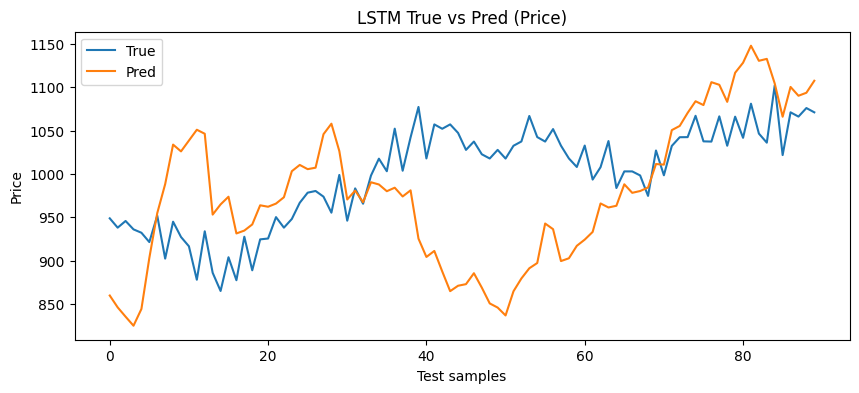

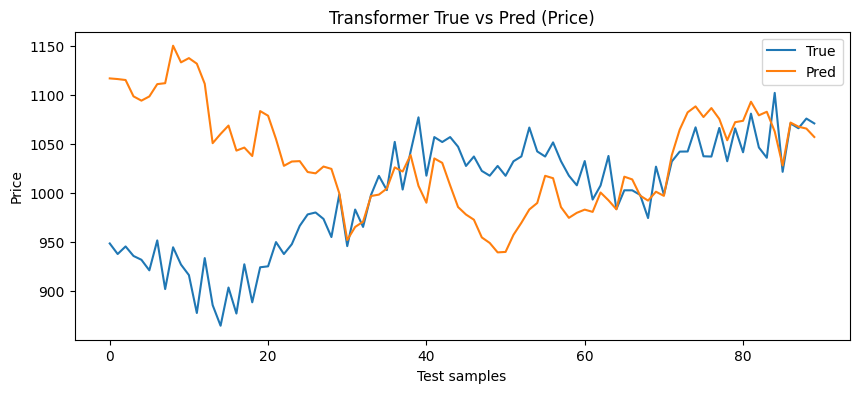

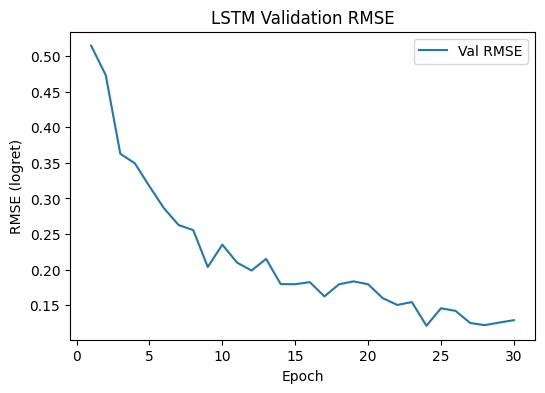

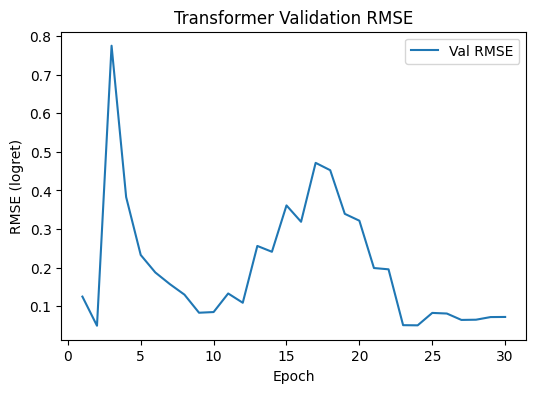

In [22]:
def plot_true_pred_price(result, title):
    plt.figure(figsize=(10,4))
    plt.plot(result['true_price'], label='True')
    plt.plot(result['pred_price'], label='Pred')
    plt.title(title)
    plt.xlabel('Test samples')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_learning_curve(history, title):
    plt.figure(figsize=(6,4))
    epochs = history['epoch']
    plt.plot(epochs, history['val_rmse'], label='Val RMSE')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE (logret)')
    plt.legend()
    plt.show()

plot_true_pred_price(res_lstm_all, 'LSTM True vs Pred (Price)')
plot_true_pred_price(res_trf_all, 'Transformer True vs Pred (Price)')

plot_learning_curve(res_lstm_all['history'], 'LSTM Validation RMSE')
plot_learning_curve(res_trf_all['history'], 'Transformer Validation RMSE')


# Transformer 注意力熱圖

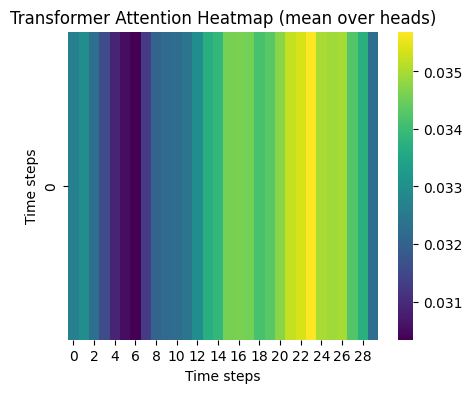

In [25]:
if res_trf_all['attn_heatmap'] is not None:
    attn = np.squeeze(res_trf_all['attn_heatmap'])  # 移除多餘維度
    if attn.ndim == 1:
        attn = attn.reshape(1, -1)
    plt.figure(figsize=(5,4))
    sns.heatmap(attn, cmap='viridis')
    plt.title('Transformer Attention Heatmap (mean over heads)')
    plt.xlabel('Time steps')
    plt.ylabel('Time steps')
    plt.show()
else:
    print("No attention weights captured.")


# 四類技術指標比較

In [26]:
def group_feature_set(group_name):
    return BASE_COLS + GROUPS[group_name]

def run_group_compare(epochs=15):
    rows = []
    for model_name in ['lstm', 'transformer']:
        for g in ['trend','oscillator','volatility','volume']:
            feats = group_feature_set(g)
            print(f"\n== {model_name.upper()} | group={g} ==")
            res = fit_and_eval(model_name, feats, epochs=epochs)
            pm = res['price_metrics']
            rows.append({
                'model': model_name,
                'group': g,
                'MSE_price': pm['MSE'],
                'MAE_price': pm['MAE'],
                'RMSE_price': pm['RMSE']
            })
    return pd.DataFrame(rows)

cmp_df = run_group_compare(epochs=15)
cmp_df



== LSTM | group=trend ==
[LSTM][Epoch 01/15] Train RMSE=0.289617 | Val RMSE=0.590929
[LSTM][Epoch 03/15] Train RMSE=0.128762 | Val RMSE=0.302267
[LSTM][Epoch 06/15] Train RMSE=0.067840 | Val RMSE=0.193524
[LSTM][Epoch 09/15] Train RMSE=0.055138 | Val RMSE=0.168953
[LSTM][Epoch 12/15] Train RMSE=0.049161 | Val RMSE=0.111686
[LSTM][Epoch 15/15] Train RMSE=0.041290 | Val RMSE=0.132788

== LSTM | group=oscillator ==
[LSTM][Epoch 01/15] Train RMSE=0.415186 | Val RMSE=0.117497
[LSTM][Epoch 03/15] Train RMSE=0.226943 | Val RMSE=0.133816
[LSTM][Epoch 06/15] Train RMSE=0.116693 | Val RMSE=0.070550
[LSTM][Epoch 09/15] Train RMSE=0.086466 | Val RMSE=0.070336
[LSTM][Epoch 12/15] Train RMSE=0.070508 | Val RMSE=0.074031
[LSTM][Epoch 15/15] Train RMSE=0.062355 | Val RMSE=0.066044

== LSTM | group=volatility ==
[LSTM][Epoch 01/15] Train RMSE=0.220280 | Val RMSE=0.433667
[LSTM][Epoch 03/15] Train RMSE=0.113166 | Val RMSE=0.334904
[LSTM][Epoch 06/15] Train RMSE=0.060721 | Val RMSE=0.148296
[LSTM][Epoch

,model,group,MSE_price,MAE_price,RMSE_price
0,lstm,trend,48961.343750,213.540970,221.272103
1,lstm,oscillator,4900.267578,59.409531,70.001911
2,lstm,volatility,1914.970093,34.881012,43.760371
3,lstm,volume,12579.625000,109.555939,112.158927
4,transformer,trend,2116.368164,39.492748,46.004002
5,transformer,oscillator,432.310883,16.510143,20.792087
6,transformer,volatility,549.070679,18.620539,23.432257
7,transformer,volume,467.603424,17.150320,21.624140


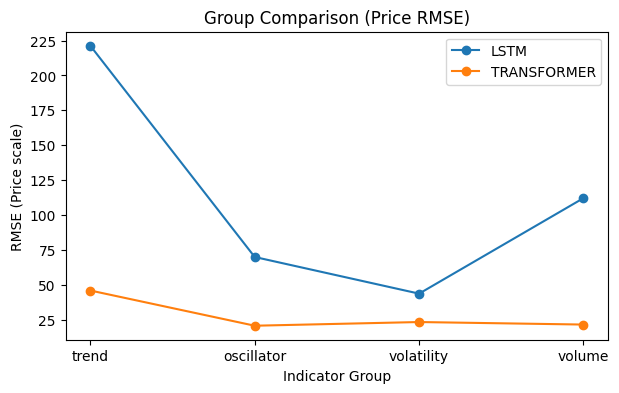

,model,group,MSE_price,MAE_price,RMSE_price
2,lstm,volatility,1914.970093,34.881012,43.760371
1,lstm,oscillator,4900.267578,59.409531,70.001911
3,lstm,volume,12579.625000,109.555939,112.158927
0,lstm,trend,48961.343750,213.540970,221.272103
5,transformer,oscillator,432.310883,16.510143,20.792087
7,transformer,volume,467.603424,17.150320,21.624140
6,transformer,volatility,549.070679,18.620539,23.432257
4,transformer,trend,2116.368164,39.492748,46.004002


In [27]:
plt.figure(figsize=(7,4))
for model_name in ['lstm','transformer']:
    sub = cmp_df[cmp_df['model']==model_name]
    plt.plot(sub['group'], sub['RMSE_price'], marker='o', label=model_name.upper())
plt.title('Group Comparison (Price RMSE)')
plt.xlabel('Indicator Group')
plt.ylabel('RMSE (Price scale)')
plt.legend()
plt.show()

# 排序檢視
cmp_df.sort_values(['model','RMSE_price'])
